<a href="https://colab.research.google.com/github/enesdemirag/cifar10-classification/blob/main/cifar10_deep_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dependencies
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras import regularizers
%matplotlib inline
%load_ext tensorboard

In [2]:
# Class labels
classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [4]:
class DeepCNN(object):
    def __init__(self):
        self.model = Sequential()

        self.model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32, 32, 3)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.2))

        self.model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.3))

        self.model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
        self.model.add(Activation('elu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.4))

        self.model.add(Flatten())
        self.model.add(Dense(10, activation='softmax'))

        self.model.compile(
            optimizer = RMSprop(lr=0.001,decay=1e-6),
            loss      = CategoricalCrossentropy(),
            metrics   = [Precision(name="precision"), Recall(name="recall"), CategoricalAccuracy(name="accuracy"), AUC(name="auc")]
        )

    def train(self, features, labels, validation_data, batch_size=32, epochs=100, shuffle=True):
        log_dir = "logs/fit/" + dt.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        history     = self.model.fit(features, labels, batch_size, epochs, shuffle=shuffle, verbose=1, validation_data=validation_data, callbacks=[tensorboard_callback, LearningRateScheduler(lr_schedule)])
        self.epochs = history.epoch
        self.hist   = pd.DataFrame(history.history)
        return self.epochs, self.hist

    def test(self, features, labels):
        self.loss, self.presicion, self.recall, self.accuracy, self.auc = self.model.evaluate(features, labels, verbose=0)
        return self.loss, self.presicion, self.recall, self.accuracy, self.auc

    def predict(self, img):
        return self.model.predict(img)

    def save(self, path="./saved_models/"):
        timestamp = dt.timestamp(dt.now())
        filename = path + "CNN_" + str(timestamp)
        
        plot_model(self.model, to_file=filename + ".png", show_shapes=True, show_layer_names=True)
        self.model.save(filename + ".h5")

    def summary(self):
        return self.model.summary()

In [5]:
# Dataset
def prepare_data():
    (images_train, labels_train), (images_test, labels_test) = cifar10.load_data()
    
    # normalize the pixel values
    images_train  = images_train.astype('float32')
    images_test   = images_test.astype('float32')
    images_train /= 255
    images_test  /= 255

    # one hot encoding
    labels_train = to_categorical(labels_train, 10)
    labels_test  = to_categorical(labels_test, 10)
    
    return images_train, labels_train, images_test, labels_test

In [6]:
# Preprocessing
images_train, labels_train, images_test, labels_test = prepare_data()

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
# Creating model
model = DeepCNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [8]:
# Training Deep CNN Model
epochs, hist = model.train(images_train, labels_train, validation_data=(images_test, labels_test), epochs=100)

Epoch 1/100
1563/1563 [==============================] - 29s 13ms/step - loss: 2.1793 - precision: 0.4533 - recall: 0.3158 - accuracy: 0.3929 - auc: 0.8099 - val_loss: 1.2125 - val_precision: 0.7075 - val_recall: 0.5468 - val_accuracy: 0.6222 - val_auc: 0.9289
Epoch 2/100
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1370 - precision: 0.7207 - recall: 0.5640 - accuracy: 0.6415 - auc: 0.9373 - val_loss: 1.2042 - val_precision: 0.7291 - val_recall: 0.5325 - val_accuracy: 0.6290 - val_auc: 0.9302
Epoch 3/100
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9356 - precision: 0.7858 - recall: 0.6440 - accuracy: 0.7122 - auc: 0.9589 - val_loss: 0.9580 - val_precision: 0.7759 - val_recall: 0.6390 - val_accuracy: 0.7065 - val_auc: 0.9579
Epoch 4/100
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8389 - precision: 0.8191 - recall: 0.6882 - accuracy: 0.7480 - auc: 0.9685 - val_loss: 1.1408 - val_precision: 0.7268 - val_recall: 0.62

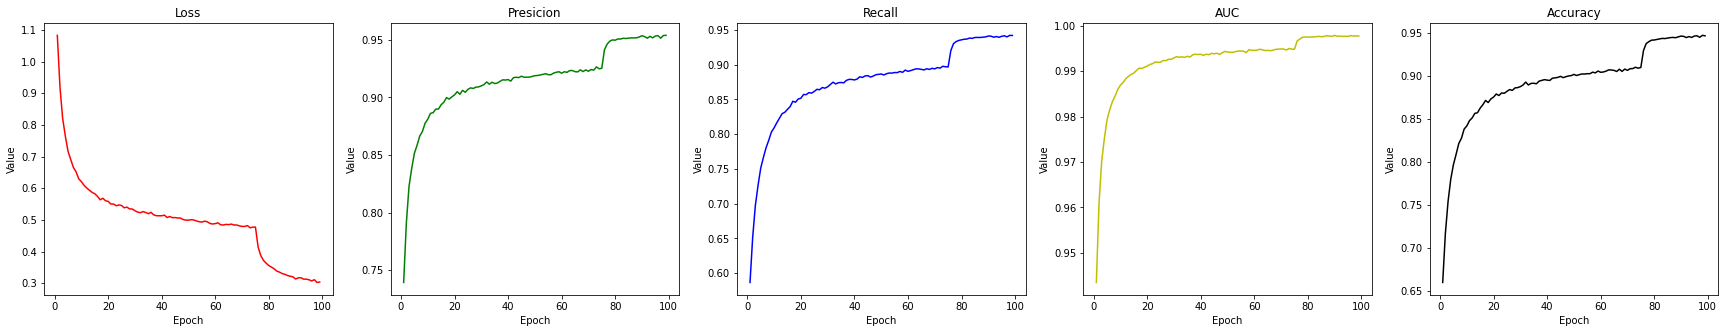

In [9]:
# Plotting the training metrics
fig, ax = plt.subplots(1, 5, figsize=(30, 5))

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Value")
ax[0].set_title("Loss")

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Value")
ax[1].set_title("Presicion")

ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Value")
ax[2].set_title("Recall")

ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Value")
ax[3].set_title("AUC")

ax[4].set_xlabel("Epoch")
ax[4].set_ylabel("Value")
ax[4].set_title("Accuracy")

ax[0].plot(epochs[1:], hist["loss"][1:], color="r")
ax[1].plot(epochs[1:], hist["precision"][1:], color="g")
ax[2].plot(epochs[1:], hist["recall"][1:], color="b")
ax[3].plot(epochs[1:], hist["auc"][1:], color="y")
ax[4].plot(epochs[1:], hist["accuracy"][1:], color="k")

In [10]:
# Testing Deep CNN Model
loss, precision, recall, accuracy, auc = model.test(images_test, labels_test)

print("--- Test Results ---")
print("%-10s: %f" %("Loss", loss))
print("%-10s: %f" %("Precision", precision))
print("%-10s: %f" %("Recall", recall))
print("%-10s: %f" %("AUC", auc))
print("%-10s: %f" %("Accuracy", accuracy))

--- Test Results ---
Loss      : 0.622073
Precision : 0.881223
Recall    : 0.862100
AUC       : 0.983124
Accuracy  : 0.869400


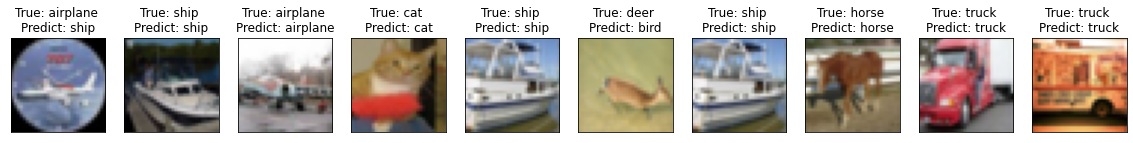

In [11]:
# Prediction Deep CNN Model	
fig, ax = plt.subplots(1, 10, figsize=(20, 5))

for i in range(10):
    rand_sample = random.randint(0, 1000)
    img = images_test[rand_sample].reshape((1, 32, 32, 3))	
    y_orig = labels_test[rand_sample]
    y_pred = model.predict(img)

    y_orig = list(y_orig).index(1)
    y_pred = [1 if i == max(y_pred[0]) else 0 for i in y_pred[0]].index(1)
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(img[0])	
    ax[i].set_title("True: %s \nPredict: %s" % (classes[y_orig], classes[y_pred]))	

In [12]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

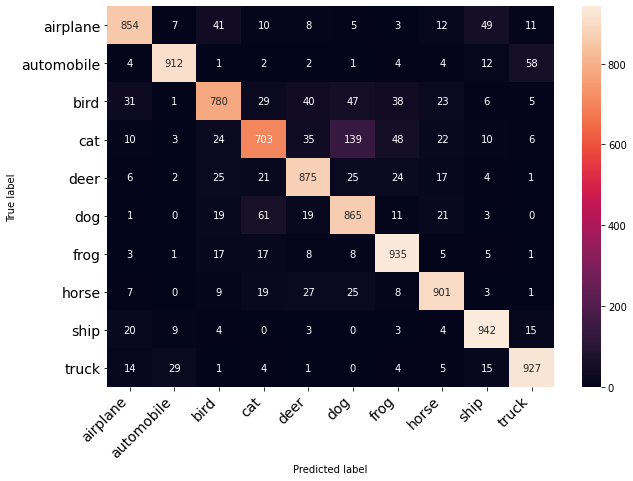

In [13]:
y_pred = np.argmax(model.predict(images_test), axis=1)
y_truth = np.argmax(labels_test, axis=1)

print_confusion_matrix(confusion_matrix(y_truth, y_pred), list(classes.values()))

In [15]:
model.model.save("model.h5")

In [ ]:
%tensorboard --logdir logs/fit